In [1]:
%load_ext autoreload  
%autoreload 2  

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ocpy.oc_lmfit import OCLMFit
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter

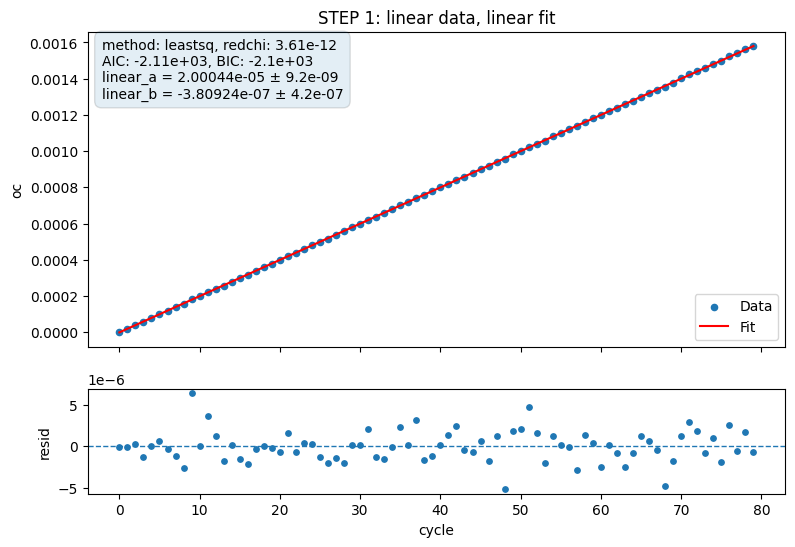

In [3]:
# ==========================
# STEP 1: sadece lineer veri
# ==========================
cycle1 = np.arange(0, 80, 1.0)
true_a = 2e-5
oc1 = true_a * cycle1 + np.random.normal(0, 2e-6, size=cycle1.size)

oc_lm1 = OCLMFit(
    oc=oc1.tolist(),
    cycle=cycle1.tolist(),
    weights=1.0,
)

res1 = oc_lm1.fit_linear()
oc_lm1.fit_and_report(res1, title="STEP 1: linear data, linear fit")

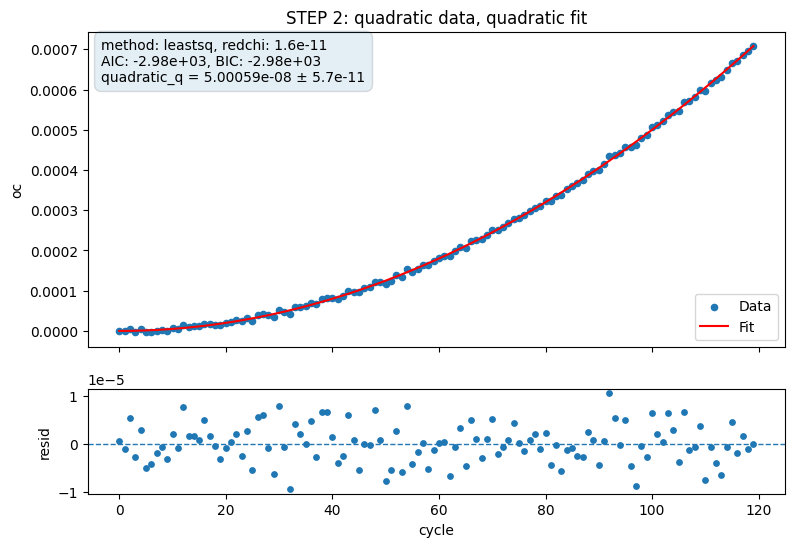

In [4]:
# ==========================
# STEP 2: sadece quadratic veri
# ==========================
cycle2 = np.arange(0, 120, 1.0)
true_q = 5e-8
oc2 = true_q * cycle2**2 + np.random.normal(0, 4e-6, size=cycle2.size)

oc_lm2 = OCLMFit(
    oc=oc2.tolist(),
    cycle=cycle2.tolist(),
    weights=1.0,
)

res2 = oc_lm2.fit_quadratic()
oc_lm2.fit_and_report(res2, title="STEP 2: quadratic data, quadratic fit")

c:\Users\Bar1\anaconda3\envs\ocpy\Lib\site-packages\lmfit\model.py:1127: UserWarning: The keyword argument T does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


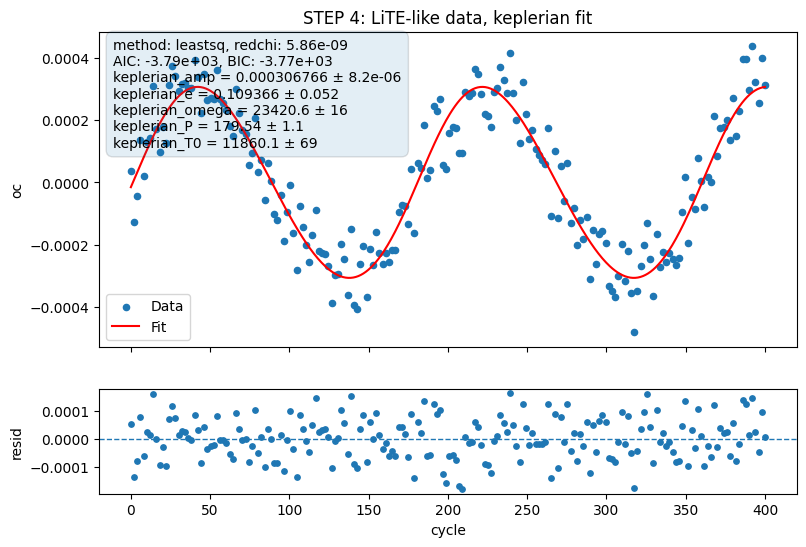

In [5]:
# ==========================
# STEP 3: LiTE benzeri sinüslü veri
# ==========================
cycle4 = np.linspace(0, 400, 200)
lite_amp = 3e-4
lite_period = 180.0
oc4 = lite_amp * np.sin(2*np.pi*cycle4 / lite_period)
oc4 += np.random.normal(0, 8e-5, size=oc4.size)

oc_lm4 = OCLMFit(
    oc=oc4.tolist(),
    cycle=cycle4.tolist(),
    weights=1.0,
)

res4 = oc_lm4.fit_keplerian(
    amp=Parameter(value=3e-4, min=0.0),
    e=Parameter(value=0.0, min=0.0, max=0.5),
    omega=Parameter(value=90.0),
    P=Parameter(value=lite_period, min=20.0, max=600.0),
    T=Parameter(value=0.0),
)
oc_lm4.fit_and_report(res4, title="STEP 4: LiTE-like data, keplerian fit")

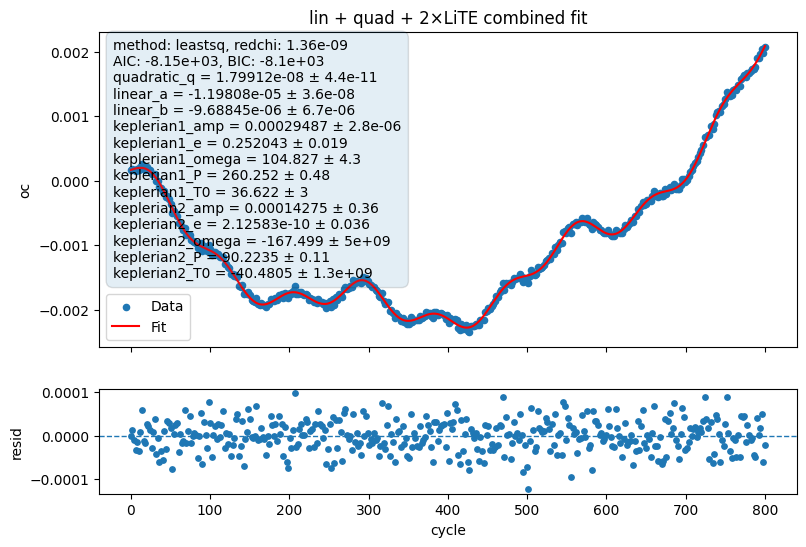

In [6]:
import numpy as np

from ocpy.oc_lmfit import OCLMFit
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter


# ==========================
# 1) sentetik veri üret
# ==========================
rng = np.random.default_rng(7)

cycle = np.linspace(0, 800, 400)  # 400 nokta

# linear
a_true = -1.2e-5
b_true = 0.0
oc_lin = a_true * cycle + b_true

# quadratic
q_true = 1.8e-8
oc_quad = q_true * cycle**2

# --- LiTE 1 (uzun dönem) ---
amp1   = 3.0e-4      # gün cinsinden OC genliği
e1     = 0.25
omega1 = np.deg2rad(110.0)
P1     = 260.0       # cycle cinsinden
T01    = 40.0

M1 = 2.0 * np.pi * (cycle - T01) / P1
E1 = M1.copy()
for _ in range(8):
    E1 = E1 - (E1 - e1*np.sin(E1) - M1) / (1 - e1*np.cos(E1))
nu1 = 2.0 * np.arctan(np.sqrt((1+e1)/(1-e1)) * np.tan(E1/2.0))

oc_lite1 = amp1 * (
    ((1 - e1**2) / (1 + e1*np.cos(nu1))) * np.sin(nu1 + omega1)
    + e1 * np.sin(omega1)
)

# --- LiTE 2 (kısa dönem) ---
amp2   = 1.4e-4
e2     = 0.05
omega2 = np.deg2rad(10.0)
P2     = 90.0         # cycle cinsinden daha kısa
T02    = 5.0

M2 = 2.0 * np.pi * (cycle - T02) / P2
E2 = M2.copy()
for _ in range(8):
    E2 = E2 - (E2 - e2*np.sin(E2) - M2) / (1 - e2*np.cos(E2))
nu2 = 2.0 * np.arctan(np.sqrt((1+e2)/(1-e2)) * np.tan(E2/2.0))

oc_lite2 = amp2 * (
    ((1 - e2**2) / (1 + e2*np.cos(nu2))) * np.sin(nu2 + omega2)
    + e2 * np.sin(omega2)
)

# hepsini topla
noise = rng.normal(0.0, 4e-5, size=cycle.size)
oc_total = oc_lin + oc_quad + oc_lite1 + oc_lite2 + noise


# ==========================
# 2) OCLMFit nesnesi
# ==========================
oc_lm = OCLMFit(
    oc=oc_total.tolist(),
    cycle=cycle.tolist(),
    weights=1.0,
)


# ==========================
# 3) 4 bileşenlik model (quad + lin + lite1 + lite2)
# ==========================
quad_comp = Quadratic(
    q=Parameter(value=1e-8)
)
lin_comp = Linear(
    a=Parameter(value=-5e-6),
    b=Parameter(value=0.0),
)

# Keplerian 1 (uzun dönem) – derece kullanıyoruz çünkü senin Keplerian içinde derece→rad vardı
kep1 = Keplerian(
    amp=Parameter(value=2.5e-4, min=0.0),
    e=Parameter(value=0.1, min=0.0, max=0.9),
    omega=Parameter(value=110.0),
    P=Parameter(value=250.0, min=50.0, max=600.0),
    T0=Parameter(value=30.0),
)

# Keplerian 2 (kısa dönem)
kep2 = Keplerian(
    amp=Parameter(value=1.0e-4, min=0.0),
    e=Parameter(value=0.05, min=0.0, max=0.8),
    omega=Parameter(value=10.0),
    P=Parameter(value=95.0, min=20.0, max=300.0),
    T0=Parameter(value=5.0),
)

# fit et
res = oc_lm.fit([quad_comp, lin_comp, kep1, kep2])

# çiz
oc_lm.fit_and_report(res, title="lin + quad + 2×LiTE combined fit")
